In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.patches import Ellipse

from astropy import units as u
from astropy import constants as const
from astropy import uncertainty as unc

from astropy.time import Time
from astropy.coordinates import SkyCoord

from uncertainties import ufloat, umath, correlated_values, covariance_matrix

from scipy import stats as st

import corner
from IPython.display import display, Math

from collections import namedtuple

In [2]:
np.random.seed(654321)

In [3]:
contour2d_sigmas = np.array([1., 2.])
contour2d_levels = 1.0 - np.exp(-0.5 * contour2d_sigmas**2)

corner_kwargs = {
    'levels':       contour2d_levels,
    'hist_kwargs':  {'density': True},
    'label_kwargs': {'size': 12},
}

linear_style = {
    'linestyle': '-',
    'linewidth': 1.5,
    'color':     'C1',
}

figsize_inches = (9.5, 9.5)

In [4]:
def overplot_linear(fig, upars, mahalanobis_radii=contour2d_sigmas, **kwargs):

    # get optimal values, standard deviations and covariance matrix
    opt = [upar.n for upar in upars]
    std = [upar.s for upar in upars]
    cov = covariance_matrix(upars)

    npoints = 100

    ndim = len(upars)
    axes = np.array(fig.axes).reshape((ndim, ndim))

    # Gaussian probability density curves
    for i in range(ndim):
        ax = axes[i, i]
        xlims = ax.get_xlim()

        x = np.linspace(xlims[0], xlims[1], npoints)
        y = st.norm.pdf(x, opt[i], std[i])

        ax.plot(x, y, **kwargs)

    # confidence ellipses
    for yi in range(ndim):
        for xi in range(yi):
            ax = axes[yi, xi]

            # ellipse centre
            opt_xy = (opt[xi], opt[yi])

            # get covariances
            cov_xx = cov[xi][xi]
            cov_yy = cov[yi][yi]
            cov_xy = cov[xi][yi]

            # compute eigenvalues and ellipse orientation
            lambda_a = ((cov_xx + cov_yy) / 2.
                        + np.sqrt((cov_xx - cov_yy)**2 / 4. + cov_xy**2))
            lambda_b = ((cov_xx + cov_yy) / 2.
                        - np.sqrt((cov_xx - cov_yy)**2 / 4. + cov_xy**2))
            theta = np.arctan2(2. * cov_xy, cov_xx - cov_yy) / 2.

            for r in mahalanobis_radii:

                # ellipse semi-axes
                semiaxis_a = r * np.sqrt(lambda_a)
                semiaxis_b = r * np.sqrt(lambda_b)

                ellipse = Ellipse(opt_xy, 2.*semiaxis_a, 2.*semiaxis_b,
                                  angle=theta*180./np.pi, zorder=2, fill=False,
                                  **kwargs)

                ax.add_patch(ellipse)

In [5]:
def get_format(fmts, i):
    if isinstance(fmts, str):
        fmt = f'{{0:{fmts}}}'.format
    else:
        fmt = f'{{0:{fmts[i]}}}'.format
    return fmt


def display_samp_quantiles(samp_array, par_strs, fmts):
    txt_all = ''
    for i, samp in enumerate(samp_array.T):
        q_16, q_50, q_84 = np.quantile(samp, [0.16, 0.5, 0.84])
        q_m, q_p = q_50 - q_16, q_84 - q_50
        fmt = get_format(fmts, i)
        if fmt(q_m) == fmt(q_p):
            txt = '{0} &= {1} \pm {2} \; {4} \\\\[0.5em]'
        else:
            txt = '{0} &= {1}_{{-{2}}}^{{+{3}}} \; {4} \\\\[0.5em]'
        txt = txt.format(par_strs[i].symbol,
                         fmt(q_50), fmt(q_m), fmt(q_p),
                         par_strs[i].unit)
        txt_all += txt

    txt_all = '\\begin{align}' + txt_all + '\\end{align}'
    display(Math(txt_all))


def display_ufloats(upars, par_strs, fmts):
    txt_all = ''
    for i, upar in enumerate(upars):
        fmt = get_format(fmts, i)
        txt_all += (f'{par_strs[i].symbol} &= '
                    f'{fmt(upar.n)} \pm {fmt(upar.s)} \; '
                    f'{par_strs[i].unit} \\\\[0.5em]')

    txt_all = '\\begin{align}' + txt_all + '\\end{align}'
    display(Math(txt_all))

In [6]:
psr_coord = SkyCoord('04h37m15.99744s -47d15m09.7170s',
                     pm_ra_cosdec=121.4385 * u.mas / u.yr,
                     pm_dec=-71.4754 * u.mas / u.yr)

p_orb_p = 5.7410459 * u.day
asini_p = 3.3667144 * const.c * u.s

k_p = 2.*np.pi * asini_p / p_orb_p

In [7]:
p_orb_e = 1. * u.yr
a_e = 1. * u.au

v_0_e = 2.*np.pi * a_e / p_orb_e

psr_coord_eclip = psr_coord.barycentricmeanecliptic
ascnod_eclip = SkyCoord(lon=psr_coord_eclip.lon - 90.*u.deg, lat=0.*u.deg,
                        frame='barycentricmeanecliptic')
ascnod_equat = ascnod_eclip.icrs

i_e = psr_coord_eclip.lat + 90.*u.deg
omega_e = psr_coord.position_angle(ascnod_equat)

In [8]:
ParString = namedtuple('ParString', ['symbol', 'unit'])

In [9]:
def gen_label_strs(par_strs):
    label_strs = [f'${par_str.symbol} \; ({par_str.unit})$'
                  for par_str in par_strs]
    return label_strs

In [10]:
par_strs_harc = [
    ParString(r'A_{\oplus,s}',   r'\mathrm{km/s/\sqrt{pc}}'),
    ParString(r'A_{\oplus,c}',   r'\mathrm{km/s/\sqrt{pc}}'),
    ParString(r'A_\mathrm{p,s}', r'\mathrm{km/s/\sqrt{pc}}'),
    ParString(r'A_\mathrm{p,s}', r'\mathrm{km/s/\sqrt{pc}}'),
    ParString(r'C',              r'\mathrm{km/s/\sqrt{pc}}')]

labels_harc = gen_label_strs(par_strs_harc)

In [11]:
par_strs_phen = [
    ParString(r'A_\oplus',        r'\mathrm{km/s/\sqrt{pc}}'),
    ParString(r'A_\mathrm{p}',    r'\mathrm{km/s/\sqrt{pc}}'),
    ParString(r'\chi_\oplus',     r'\mathrm{deg}'),
    ParString(r'\chi_\mathrm{p}', r'\mathrm{deg}'),
    ParString(r'C',               r'\mathrm{km/s/\sqrt{pc}}')]

labels_phen = gen_label_strs(par_strs_phen)

In [12]:
par_strs_phys = [
    ParString(r'i_\mathrm{p}',              r'\mathrm{deg}'),
    ParString(r'\Omega_\mathrm{p}',         r'\mathrm{deg}'),
    ParString(r'd_\mathrm{p}',              r'\mathrm{pc}'),
    ParString(r'd_\mathrm{s}',              r'\mathrm{pc}'),
    ParString(r'\xi',                       r'\mathrm{deg}'),
    ParString(r'v_\mathrm{lens,\parallel}', r'\mathrm{km/s}')]

labels_phys = gen_label_strs(par_strs_phys)

In [13]:
def pars_phen2harc(pars_phen):

    amp_e, amp_p, chi_e, chi_p, dveff_c = pars_phen

    hc_es = amp_e * np.cos(chi_e)
    hc_ec = amp_e * np.sin(chi_e)
    hc_ps = amp_p * np.cos(chi_p)
    hc_pc = amp_p * np.sin(chi_p)
    hc_0 = dveff_c

    pars_harc = (
        hc_es.to(u.km/u.s/u.pc**0.5),
        hc_ec.to(u.km/u.s/u.pc**0.5),
        hc_ps.to(u.km/u.s/u.pc**0.5),
        hc_pc.to(u.km/u.s/u.pc**0.5),
        hc_0.to(u.km/u.s/u.pc**0.5),
    )

    return pars_harc

In [14]:
def pars_harc2phen(pars_harc):

    hc_es, hc_ec, hc_ps, hc_pc, hc_0 = pars_harc

    amp_e = np.sqrt(hc_es**2 + hc_ec**2)
    amp_p = np.sqrt(hc_ps**2 + hc_pc**2)
    chi_e = np.arctan2(hc_ec, hc_es) % (360.*u.deg)
    chi_p = np.arctan2(hc_pc, hc_ps) % (360.*u.deg)
    dveff_c = hc_0

    pars_phen = (
        amp_e.to(u.km/u.s/u.pc**0.5),
        amp_p.to(u.km/u.s/u.pc**0.5),
        chi_e.to(u.deg),
        chi_p.to(u.deg),
        dveff_c.to(u.km/u.s/u.pc**0.5),
    )

    return pars_phen

In [15]:
def upars_harc2phen(upars_harc):
    # units used:
    # angles: rad (internally), deg (output)
    # scaled effective velocities: km/s/sqrt(pc)

    hc_es, hc_ec, hc_ps, hc_pc, hc_0 = upars_harc

    amp_e = umath.sqrt(hc_es**2 + hc_ec**2)
    amp_p = umath.sqrt(hc_ps**2 + hc_pc**2)
    chi_e = umath.atan2(hc_ec, hc_es) % (2.*np.pi)
    chi_p = umath.atan2(hc_pc, hc_ps) % (2.*np.pi)
    dveff_c = hc_0

    upars_phen = (
        amp_e,
        amp_p,
        umath.degrees(chi_e),
        umath.degrees(chi_p),
        dveff_c
    )

    return upars_phen

In [16]:
def pars_phys2phen(pars_phys):

    i_p, omega_p, d_p, d_s, xi, v_lens = pars_phys

    d_eff = d_p * d_s / (d_p - d_s)
    s = 1. - d_s / d_p

    delta_omega_e = xi - omega_e
    b2_e = (np.cos(delta_omega_e)**2 +
            np.sin(delta_omega_e)**2 * np.cos(i_e)**2)

    delta_omega_p = xi - omega_p
    b2_p = (np.cos(delta_omega_p)**2 +
            np.sin(delta_omega_p)**2 * np.cos(i_p)**2)

    amp_e = v_0_e / np.sqrt(d_eff) * np.sqrt(b2_e)
    amp_p = (np.sqrt(d_eff) / d_p
             * k_p / np.sin(i_p) * np.sqrt(b2_p))

    chi_e = np.arctan2(np.sin(delta_omega_e) * np.cos(i_e),
                       np.cos(delta_omega_e)) % (360.*u.deg)
    chi_p = np.arctan2(np.sin(delta_omega_p) * np.cos(i_p),
                       np.cos(delta_omega_p)) % (360.*u.deg)

    mu_p_sys = (psr_coord.pm_ra_cosdec * np.sin(xi) +
                psr_coord.pm_dec * np.cos(xi))
    v_p_sys = (d_p * mu_p_sys
              ).to(u.km/u.s, equivalencies=u.dimensionless_angles())
    dveff_c = (1. / s * v_lens / np.sqrt(d_eff)
               - (1. - s) / s * v_p_sys / np.sqrt(d_eff))

    pars_phen = (
        amp_e.to(u.km/u.s/u.pc**0.5),
        amp_p.to(u.km/u.s/u.pc**0.5),
        chi_e.to(u.deg),
        chi_p.to(u.deg),
        dveff_c.to(u.km/u.s/u.pc**0.5),
    )

    return pars_phen

In [17]:
def pars_phen2phys_d_p(pars_phen, d_p, cos_sign):

    amp_e, amp_p, chi_e, chi_p, dveff_c = pars_phen

    # screen angle
    delta_omega_e = np.arctan2(np.sin(chi_e) / np.cos(i_e), np.cos(chi_e))
    xi = (delta_omega_e + omega_e) % (360.*u.deg)

    # effective distance
    b2_e = (1. - np.sin(i_e)**2) / (1. - np.sin(i_e)**2 * np.cos(chi_e)**2)
    d_eff = v_0_e**2 / amp_e**2 * b2_e

    # screen distance, fractional pulsar-screen distance
    d_s = d_p * d_eff / (d_p + d_eff)
    s = 1. - d_s / d_p

    # pulsar orbital inclination
    z2 = b2_e * (v_0_e * k_p / (amp_e * amp_p * d_p))**2
    cos2chi_p = np.cos(chi_p)**2
    discrim = (1. + z2)**2 - 4. * cos2chi_p * z2
    sin2i_p = 2. * z2 / (1. + z2 + np.sqrt(discrim))
    cosi_p = cos_sign * np.sqrt(1. - sin2i_p)
    i_p = np.arccos(cosi_p) % (180.*u.deg)

    # pulsar longitude of ascending node
    delta_omega_p = np.arctan2(np.sin(chi_p) / cosi_p, np.cos(chi_p))
    omega_p = (xi - delta_omega_p) % (360.*u.deg)

    # screen velocity
    mu_p_sys = (psr_coord.pm_ra_cosdec * np.sin(xi) +
                psr_coord.pm_dec * np.cos(xi))
    v_eff_p_sys = (d_eff * mu_p_sys
                ).to(u.km/u.s, equivalencies=u.dimensionless_angles())
    v_lens = s * (v_eff_p_sys + np.sqrt(d_eff) * dveff_c)

    pars_phys = (
        i_p.to(u.deg),
        omega_p.to(u.deg),
        d_p.to(u.pc),
        d_s.to(u.pc),
        xi.to(u.deg),
        v_lens.to(u.km/u.s),
    )

    return pars_phys

In [18]:
def upars_phen2phys_d_p(upars_phen, d_p, cos_sign):
    # these units are used:
    # velocities: km/s
    # distances: pc
    # angles: rad (internally), deg (input/output)
    # proper motion: mas/yr
    # scaled effective velocities: km/s/sqrt(pc)

    amp_e, amp_p, chi_e, chi_p, dveff_c = upars_phen
    chi_e = umath.radians(chi_e)
    chi_p = umath.radians(chi_p)

    # screen angle
    delta_omega_e = umath.atan2((umath.sin(chi_e)
                                 / umath.cos(i_e.to_value(u.rad))),
                                umath.cos(chi_e))
    xi = (delta_omega_e + omega_e.to_value(u.rad)) % (2.*np.pi)

    # effective distance
    b2_e = ((1. - umath.sin(i_e.to_value(u.rad))**2) /
            (1. - umath.sin(i_e.to_value(u.rad))**2 * umath.cos(chi_e)**2))
    d_eff = v_0_e.to_value(u.km/u.s)**2 / amp_e**2 * b2_e

    # screen distance, fractional pulsar-screen distance
    d_s = d_p * d_eff / (d_p + d_eff)
    s = 1. - d_s / d_p

    # pulsar orbital inclination
    z2 = b2_e * (v_0_e.to_value(u.km/u.s) * k_p.to_value(u.km/u.s)
                 / (amp_e * amp_p * d_p))**2
    cos2chi_p = umath.cos(chi_p)**2
    discrim = (1. + z2)**2 - 4. * cos2chi_p * z2
    sin2i_p = 2. * z2 / (1. + z2 + umath.sqrt(discrim))
    cosi_p = cos_sign * umath.sqrt(1. - sin2i_p)
    i_p = umath.acos(cosi_p) % (np.pi)

    # pulsar longitude of ascending node
    delta_omega_p = umath.atan2(umath.sin(chi_p) / cosi_p, umath.cos(chi_p))
    omega_p = (xi - delta_omega_p) % (2.*np.pi)

    # screen velocity
    mu_p_sys = (psr_coord.pm_ra_cosdec.to_value(u.mas/u.yr) * umath.sin(xi) +
                psr_coord.pm_dec.to_value(u.mas/u.yr) * umath.cos(xi))
    v_eff_p_sys = d_eff * mu_p_sys * (1.e-3 * u.au/u.km * u.s/u.yr
                                     ).to_value(u.dimensionless_unscaled)
    v_lens = s * (v_eff_p_sys + umath.sqrt(d_eff) * dveff_c)

    upars_phys = (
        umath.degrees(i_p),
        umath.degrees(omega_p),
        d_p,
        d_s,
        umath.degrees(xi),
        v_lens,
    )

    return upars_phys

In [19]:
truths_phys = (
    137.56 * u.deg,    # i_p
    207.0  * u.deg,    # omega_p
    156.79 * u.pc,     # d_p
     90.6  * u.pc,     # d_s
    134.6  * u.deg,    # xi
    -31.9  * u.km/u.s, # v_lens
)

truths_phys_list = [par.value for par in truths_phys]

In [20]:
truths_phen = pars_phys2phen(truths_phys)
truths_phen_list = [par.value for par in truths_phen]

truths_harc = pars_phen2harc(truths_phen)
truths_harc_list = [par.value for par in truths_harc]

In [21]:
fit_results = np.load('./data/fit-results-J0437.npz')

popt = fit_results['popt']
pcov = fit_results['pcov']

In [22]:
sol_sign_choice = -1
cos_sign_choice = -1

In [23]:
nmc = 40000

In [24]:
rnd_sign = np.random.randint(low=0, high=2, size=nmc) * 2 - 1
sol_sign = unc.Distribution(rnd_sign)

In [25]:
hcs = np.random.multivariate_normal(popt, pcov, size=nmc)

# separate harmonic coefficients
hc_es = sol_sign * unc.Distribution(hcs[:, 0] * u.km/u.s/u.pc**0.5)
hc_ec = sol_sign * unc.Distribution(hcs[:, 1] * u.km/u.s/u.pc**0.5)
hc_ps = sol_sign * unc.Distribution(hcs[:, 2] * u.km/u.s/u.pc**0.5)
hc_pc = sol_sign * unc.Distribution(hcs[:, 3] * u.km/u.s/u.pc**0.5)
hc_0  = sol_sign * unc.Distribution(hcs[:, 4] * u.km/u.s/u.pc**0.5)

samp_harc = (hc_es, hc_ec, hc_ps, hc_pc, hc_0)

samp_harc_all = [dist.distribution.value for dist in samp_harc]
samp_harc_all = np.stack(samp_harc_all, axis=1)

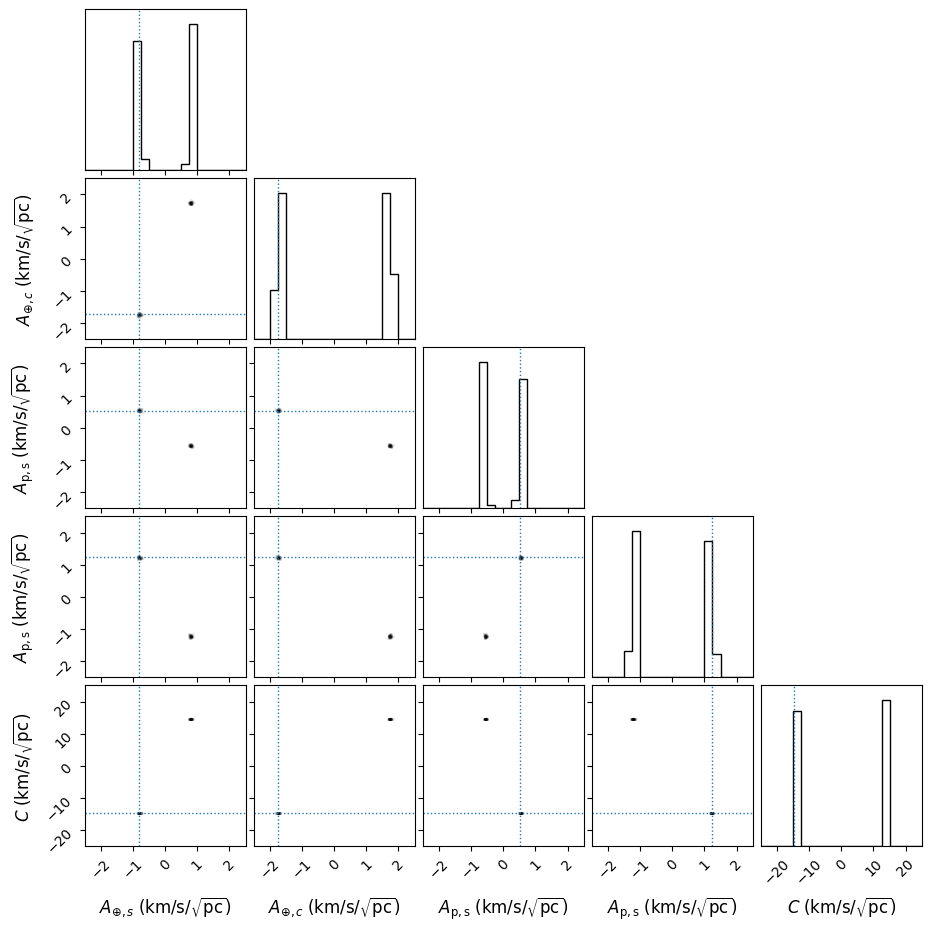

In [26]:
ranges_harc = [
    (-2.5, 2.5),
    (-2.5, 2.5),
    (-2.5, 2.5),
    (-2.5, 2.5),
    (-25., 25.),
]

fig = corner.corner(samp_harc_all[::400, :], labels=labels_harc,
                    range=ranges_harc, plot_contours=False, plot_density=False,
                    **corner_kwargs)

corner.core.overplot_lines(fig, truths_harc_list, lw=1, ls=':')

fig.set_size_inches(figsize_inches)

plt.show()

In [27]:
indices = (sol_sign.distribution == sol_sign_choice)

samp_harc_sel = samp_harc_all[indices, :]

display_samp_quantiles(samp_harc_sel, par_strs_harc, '.3f')

<IPython.core.display.Math object>

In [28]:
upars_harc = correlated_values(sol_sign_choice * popt, pcov)

display_ufloats(upars_harc, par_strs_harc, '.3f')

<IPython.core.display.Math object>

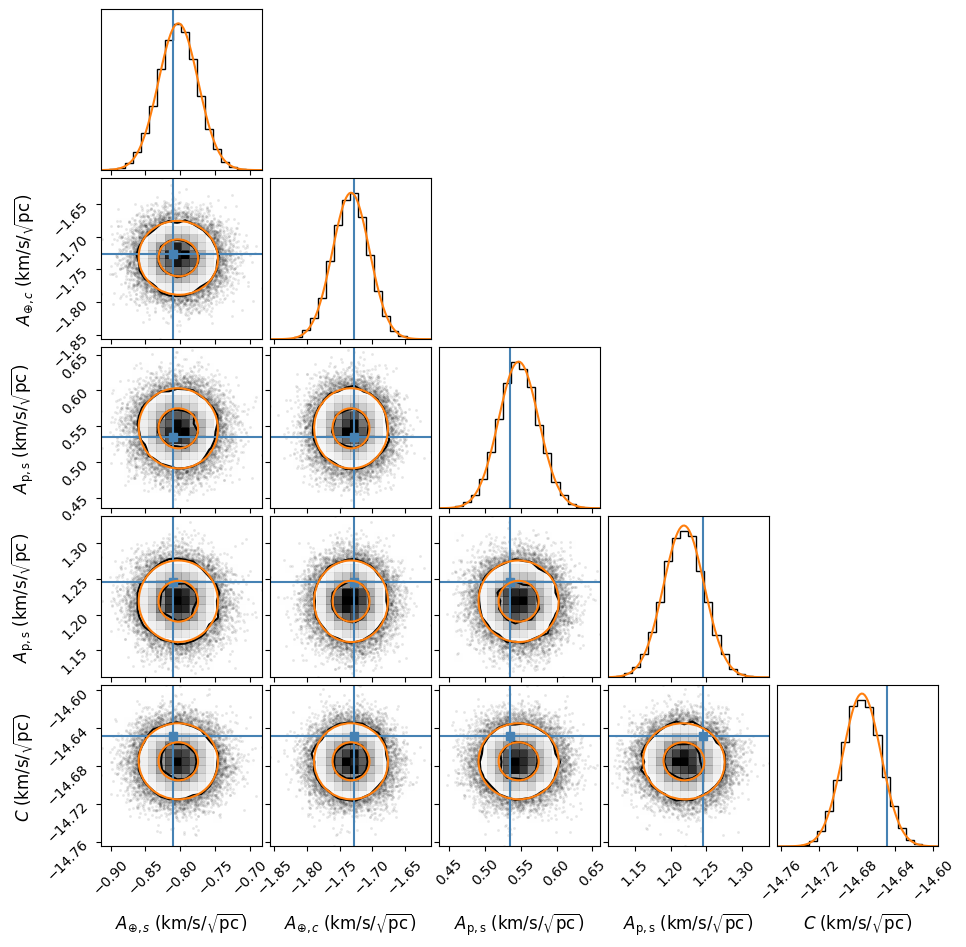

In [29]:
fig = corner.corner(samp_harc_sel, labels=labels_harc, truths=truths_harc_list,
                    labelpad=0.1, **corner_kwargs)

overplot_linear(fig, upars_harc, **linear_style)

fig.set_size_inches(figsize_inches)

plt.show()

In [30]:
samp_phen = pars_harc2phen(samp_harc)

samp_phen_all = [dist.distribution.value for dist in samp_phen]
samp_phen_all = np.stack(samp_phen_all, axis=1)

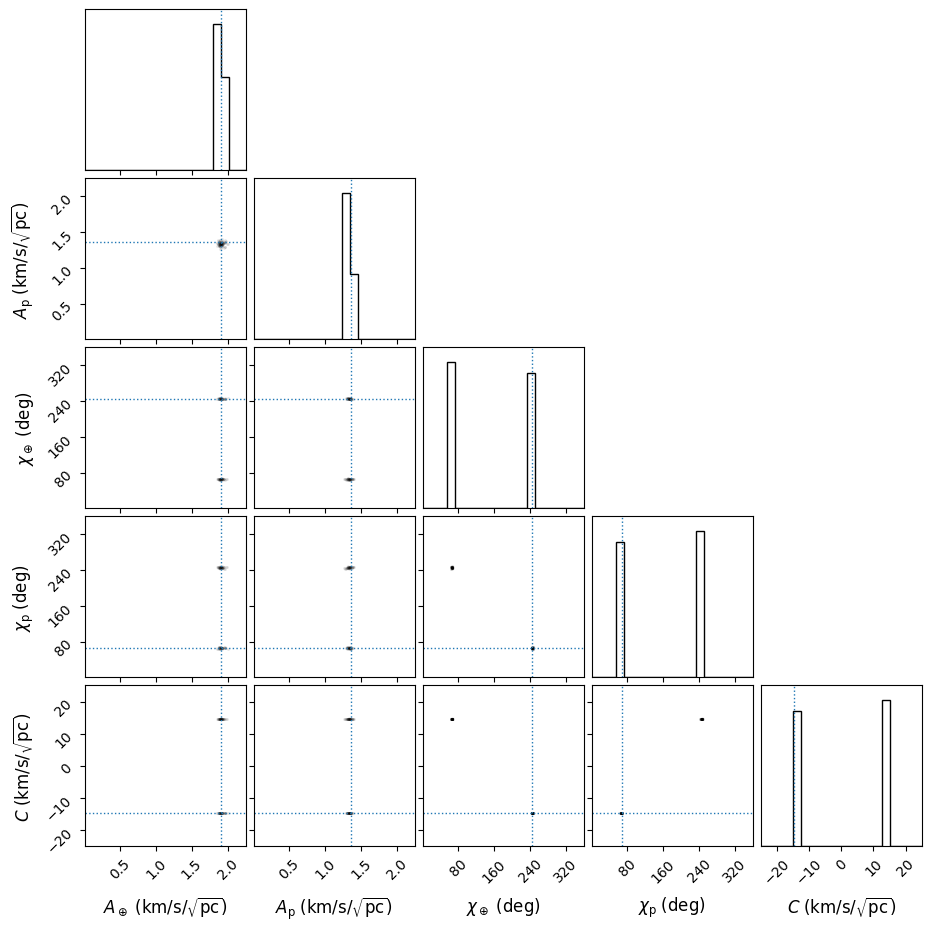

In [31]:
ranges_phen = [
    (0., 2.25),
    (0., 2.25),
    (0., 360.),
    (0., 360.),
    (-25., 25.),
]

fig = corner.corner(samp_phen_all[::400, :], labels=labels_phen,
                    range=ranges_phen, plot_contours=False, plot_density=False,
                    **corner_kwargs)

corner.core.overplot_lines(fig, truths_phen_list, lw=1, ls=':')

fig.set_size_inches(figsize_inches)

plt.show()

In [32]:
indices = (sol_sign.distribution == sol_sign_choice)

samp_phen_sel = samp_phen_all[indices, :]

fmts_phen = ['.3f', '.3f', '.2f', '.1f', '.3f']
display_samp_quantiles(samp_phen_sel, par_strs_phen, fmts_phen)

<IPython.core.display.Math object>

In [33]:
upars_phen = upars_harc2phen(upars_harc)

display_ufloats(upars_phen, par_strs_phen, fmts_phen)

<IPython.core.display.Math object>

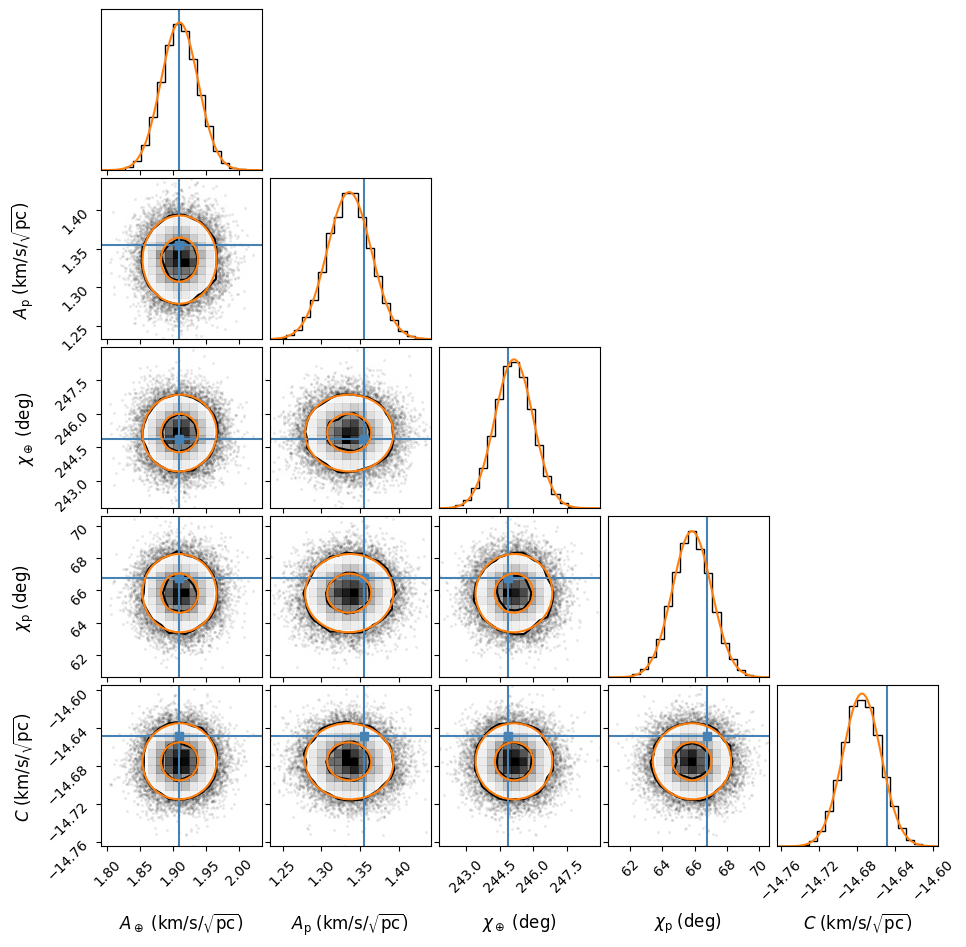

In [34]:
fig = corner.corner(samp_phen_sel, labels=labels_phen, truths=truths_phen_list,
                    labelpad=0.1, **corner_kwargs)

overplot_linear(fig, upars_phen, **linear_style)

fig.set_size_inches(figsize_inches)

plt.show()

In [35]:
d_p_mu = 200. * u.pc
d_p_sig = 60. * u.pc

In [36]:
d_p_iter = np.random.normal(size=nmc) * d_p_sig + d_p_mu

while np.any(d_p_iter <= 0):
    ind_neg = np.where(d_p_iter <= 0)
    d_p_replace = np.random.normal(size=len(ind_neg[0])) * d_p_sig + d_p_mu
    d_p_iter[ind_neg] = d_p_replace

samp_d_p = unc.Distribution(d_p_iter)

In [37]:
rnd_sign = np.random.randint(low=0, high=2, size=nmc) * 2 - 1
cos_sign = unc.Distribution(rnd_sign)

In [38]:
samp_phys = pars_phen2phys_d_p(samp_phen, samp_d_p, cos_sign)

samp_phys_all = [dist.distribution.value for dist in samp_phys]
samp_phys_all = np.stack(samp_phys_all, axis=1)

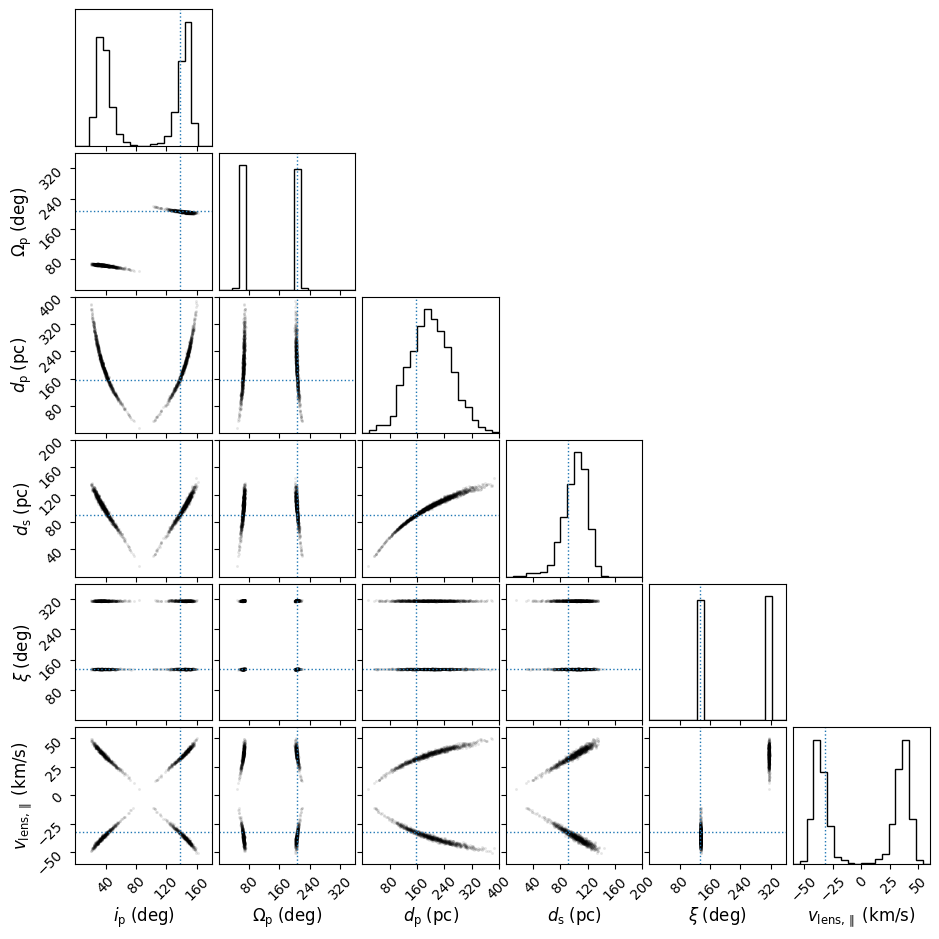

In [39]:
ranges_phys = [
    (0., 180.),
    (0., 360.),
    (0., 400.),
    (0., 200.),
    (0., 360.),
    (-60., 60.),
]

fig = corner.corner(samp_phys_all[::20, :], labels=labels_phys,
                    range=ranges_phys, plot_contours=False, plot_density=False,
                    **corner_kwargs)

corner.core.overplot_lines(fig, truths_phys_list, lw=1, ls=':')

fig.set_size_inches(figsize_inches)

plt.show()

In [40]:
cos_sign_choice = -1

indices = ((sol_sign.distribution == sol_sign_choice) &
           (cos_sign.distribution == cos_sign_choice))

samp_phys_sel = samp_phys_all[indices, :]

fmts_phys = ['.0f', '.1f', '.0f', '.0f', '.2f', '.1f']
display_samp_quantiles(samp_phys_sel, par_strs_phys, fmts_phys)

<IPython.core.display.Math object>

In [41]:
ud_p = ufloat(d_p_mu.to_value(u.pc), d_p_sig.to_value(u.pc))

In [42]:
upars_phys = upars_phen2phys_d_p(upars_phen, ud_p, cos_sign_choice)

display_ufloats(upars_phys, par_strs_phys, fmts_phys)

<IPython.core.display.Math object>

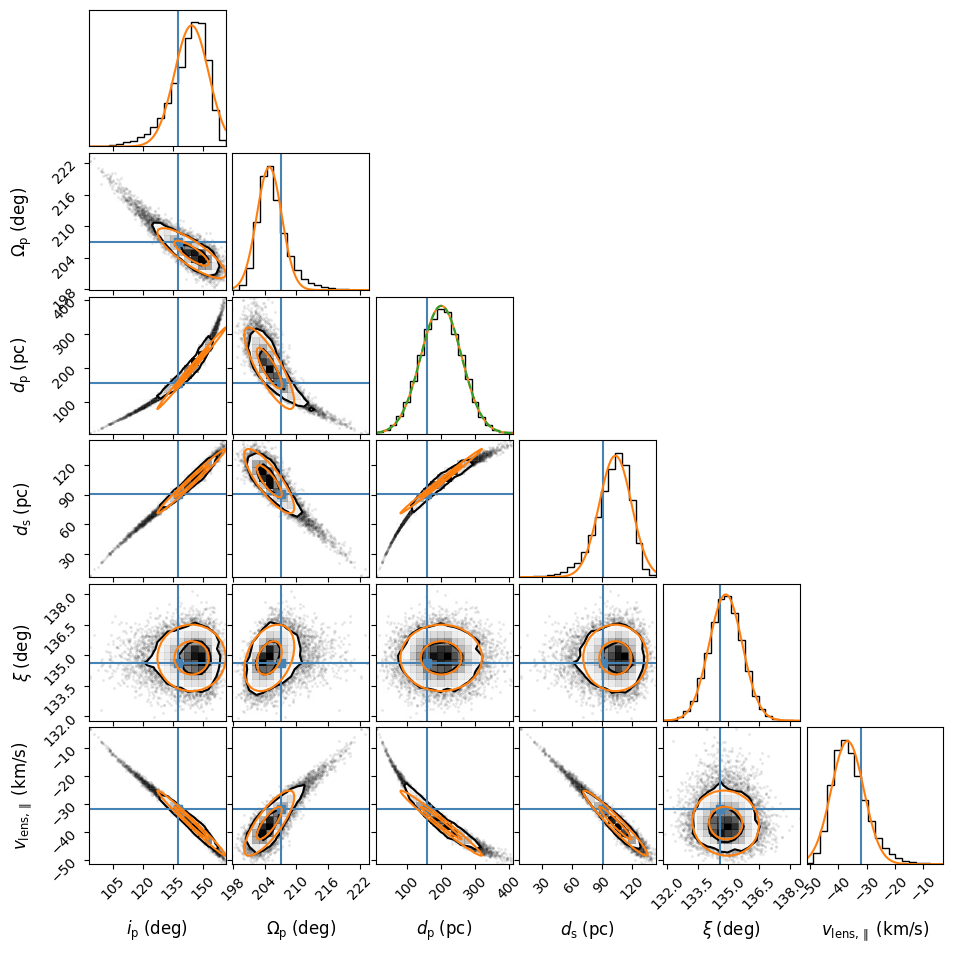

In [43]:
fig = corner.corner(samp_phys_sel, labels=labels_phys, truths=truths_phys_list,
                    labelpad=0.1, **corner_kwargs)

overplot_linear(fig, upars_phys, **linear_style)

ndim_phys = 6
idim_d_p = 2
npoints = 100

axes = np.array(fig.axes).reshape((ndim_phys, ndim_phys))

# d_p prior
ax = axes[idim_d_p, idim_d_p]
xlims = ax.get_xlim()

d_p_all = np.linspace(xlims[0], xlims[1], npoints) * u.pc
d_p_prior = st.norm.pdf(d_p_all.to_value(u.pc),
                        d_p_mu.to_value(u.pc),
                        d_p_sig.to_value(u.pc))

ax.plot(d_p_all.to_value(u.pc), d_p_prior, '--', color='C2')

fig.set_size_inches(figsize_inches)

fig.set_size_inches(figsize_inches)

plt.show()